In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import os

# Ganti dengan folder tempat CSV kamu
BASE_PATH = "/content/drive/MyDrive/DataOSSN"

users_df      = pd.read_csv(os.path.join(BASE_PATH, "ossn_users.csv"))
relations_df  = pd.read_csv(os.path.join(BASE_PATH, "ossn_relationships.csv"))
objects_df    = pd.read_csv(os.path.join(BASE_PATH, "ossn_object.csv"))
likes_df      = pd.read_csv(os.path.join(BASE_PATH, "ossn_likes.csv"))
ann_df        = pd.read_csv(os.path.join(BASE_PATH, "ossn_annotations.csv"))

users_df.head()


,guid,type,username,email,password,salt,first_name,last_name,last_login,last_activity,activation,time_created,time_updated
0,1,admin,INIADMIN,elgafirmantara27@gmail.com,$2y$10$rIV5mfes23jaX5Z.wP.54udwIFzCCqC/QL3BIum...,5256ee4a,System,Administrator,1764066456,1764067639,NaN,1763464485,1763558141
1,2,normal,Suryajayadi,suryajayadi34@gmail.com,$2y$10$vpGKan0qr3BI8p55uHydOOX4Q1btt4XvgpAD9Ed...,747d3f96,Surya,Jayadi34,1763562728,1763562742,NaN,1763465031,1763469037
2,3,normal,KhoirulFuad,khoirulfuad55@gmail.com,$2y$10$rFledCyCH91Q39oPpRVP..0QHNKgfThmfEcdTlD...,7e80c67d,Khoirul,Fuad,1763607848,1763608930,NaN,1763465192,1763468918
3,4,normal,ErikBakrie1,erikbakrie1@gmail.com,$2y$10$Ff5dcNHNQLrFchbO3OBFt.g.R3f8T5G0kP/is5H...,809cdb93,Erik,Bakrie1,1763474840,1763475197,NaN,1763465225,1763465225
4,5,normal,BahlilGo,anime45@gmail.com,$2y$10$Wwj70kKed/zHa63gWbeJZuQX8gN/hXomox0Uo9D...,832f0ace,Bahlil,Sugianto,1763561322,1763562314,NaN,1763465267,1763470493


In [4]:
# Buang user dengan type = 'admin'
users_non_admin = users_df[users_df["type"] != "admin"].copy()

# Ambil kolom dasar: id, username, last_activity
user_features = users_non_admin[["guid", "username"]].copy()
user_features.rename(columns={"guid": "user_id"}, inplace=True)

user_features.head()


,user_id,username
1,2,Suryajayadi
2,3,KhoirulFuad
3,4,ErikBakrie1
4,5,BahlilGo
5,6,Maulanaaa


In [5]:
# Hitung jumlah post (owner_guid = user pemilik post)
posts_per_user = (
    objects_df
    .groupby("owner_guid")
    .size()
    .reset_index(name="jumlah_postingan")
    .rename(columns={"owner_guid": "user_id"})
)


# 1) LIKE DIBERIKAN: berapa kali user memberi like
like_diberikan = (
    likes_df
    .groupby("subject_id")
    .size()
    .reset_index(name="like_diberikan")
    .rename(columns={"subject_id": "user_id"})
)

# 2) LIKE DITERIMA: berapa kali postingan user di-like
# Join likes -> objects untuk tahu pemilik posting yang di-like
likes_with_owner = likes_df.merge(
    objects_df[["guid", "owner_guid"]],
    left_on="subject_id",
    right_on="guid",
    how="inner"
)

like_diterima = (
    likes_with_owner
    .groupby("owner_guid")
    .size()
    .reset_index(name="like_diterima")
    .rename(columns={"owner_guid": "user_id"})
)

# 1) KOMEN DIBERIKAN: berapa komentar yang user tulis
komen_diberikan = (
    ann_df
    .groupby("owner_guid")
    .size()
    .reset_index(name="komen_diberikan")
    .rename(columns={"owner_guid": "user_id"})
)

# 2) KOMEN DITERIMA: komentar yang masuk ke postingan user
# Asumsi: ann_df.subject_guid = id post (guid di objects_df)

# Siapkan objek dengan nama kolom owner_guid yang beda
objects_for_merge = objects_df[["guid", "owner_guid"]].rename(
    columns={"owner_guid": "post_owner_id"}
)

ann_with_owner = ann_df.merge(
    objects_for_merge,
    left_on="subject_guid",   # id post di annotations
    right_on="guid",          # id post di objects
    how="inner"
)

# Sekarang kolom pemilik post = post_owner_id
komen_diterima = (
    ann_with_owner
    .groupby("post_owner_id")
    .size()
    .reset_index(name="komen_diterima")
    .rename(columns={"post_owner_id": "user_id"})
)

In [6]:
# Filter hanya relasi bertipe friend:...
relations_filtered = relations_df[relations_df["type"].str.startswith("friend:", na=False)].copy()

# Dua sisi hubungan: from dan to dianggap teman
rel_from = relations_filtered[["relation_from", "relation_to"]].rename(
    columns={"relation_from": "user_id", "relation_to": "friend_id"}
)
rel_to = relations_filtered[["relation_to", "relation_from"]].rename(
    columns={"relation_to": "user_id", "relation_from": "friend_id"}
)

# Gabungkan dua sisi dan buang duplikat
all_rel = pd.concat([rel_from, rel_to], ignore_index=True).drop_duplicates()

# Hitung jumlah teman unik per user
jumlah_teman = (
    all_rel
    .groupby("user_id")["friend_id"]
    .nunique()
    .reset_index(name="jumlah_teman")
)

jumlah_teman.head()


,user_id,jumlah_teman
0,2,5
1,3,5
2,4,1
3,5,6
4,6,4


In [7]:
# Merge bertahap
for df_feat in [
    posts_per_user,
    like_diberikan,
    like_diterima,
    komen_diberikan,
    komen_diterima,
    jumlah_teman
]:
    user_features = user_features.merge(df_feat, on="user_id", how="left")

# Isi NaN dengan 0 untuk kolom hitungan
count_cols = [
    "jumlah_postingan",
    "like_diberikan",
    "like_diterima",
    "komen_diberikan",
    "komen_diterima",
    "jumlah_teman"
]

for c in count_cols:
    if c in user_features.columns:
        user_features[c] = user_features[c].fillna(0).astype(int)

user_features.head()


,user_id,username,jumlah_postingan,like_diberikan,like_diterima,komen_diberikan,komen_diterima,jumlah_teman
0,2,Suryajayadi,11,1,1383,11,3,5
1,3,KhoirulFuad,12,0,10,4,8,5
2,4,ErikBakrie1,10,0,1076,1,3,1
3,5,BahlilGo,12,0,1455,11,1,6
4,6,Maulanaaa,17,0,3593,1,2,4


In [8]:
output_path = os.path.join(BASE_PATH, "user_features_final_pandas.csv")
user_features.to_csv(output_path, index=False)
print("Tabel fitur final (non-admin) disimpan di:", output_path)

Tabel fitur final (non-admin) disimpan di: /content/drive/MyDrive/DataOSSN/user_features_final_pandas.csv


In [9]:
user_features.isna().sum()


,0
user_id,0
username,0
jumlah_postingan,0
like_diberikan,0
like_diterima,0
komen_diberikan,0
komen_diterima,0
jumlah_teman,0


In [10]:
user_features.duplicated().sum()
user_features['user_id'].duplicated().sum()


0

In [11]:
import numpy as np

numeric_cols = user_features.select_dtypes(include=['int64', 'float64']).columns

outlier_summary = {}

for col in numeric_cols:
    q1 = user_features[col].quantile(0.25)
    q3 = user_features[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (user_features[col] < lower) | (user_features[col] > upper)
    outlier_summary[col] = {
        "q1": q1,
        "q3": q3,
        "iqr": iqr,
        "lower": lower,
        "upper": upper,
        "n_outliers": int(mask.sum())
    }

pd.DataFrame(outlier_summary).T


,q1,q3,iqr,lower,upper,n_outliers
user_id,90.25,254.75,164.5,-156.5,501.5,0.0
jumlah_postingan,2.00,5.00,3.0,-2.5,9.5,16.0
like_diberikan,129.00,299.00,170.0,-126.0,554.0,0.0
like_diterima,0.00,0.00,0.0,0.0,0.0,41.0
komen_diberikan,129.00,226.00,97.0,-16.5,371.5,0.0
komen_diterima,60.00,299.00,239.0,-298.5,657.5,0.0
jumlah_teman,6.00,6.00,0.0,6.0,6.0,49.0


In [12]:
# Jika lanjut dari proses sebelumnya:
df = user_features.copy()

# Kalau mulai dari awal notebook, pakai ini:
# df = pd.read_csv(os.path.join(BASE_PATH, "user_features_final_pandas.csv"))

df.head()


,user_id,username,jumlah_postingan,like_diberikan,like_diterima,komen_diberikan,komen_diterima,jumlah_teman
0,2,Suryajayadi,11,1,1383,11,3,5
1,3,KhoirulFuad,12,0,10,4,8,5
2,4,ErikBakrie1,10,0,1076,1,3,1
3,5,BahlilGo,12,0,1455,11,1,6
4,6,Maulanaaa,17,0,3593,1,2,4


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7a739ad8c180>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


k = 2, inertia = 1146.42
k = 3, inertia = 815.75
k = 4, inertia = 648.86
k = 5, inertia = 517.04
k = 6, inertia = 414.19
k = 7, inertia = 363.48
k = 8, inertia = 312.23
k = 9, inertia = 273.00
k = 10, inertia = 254.49


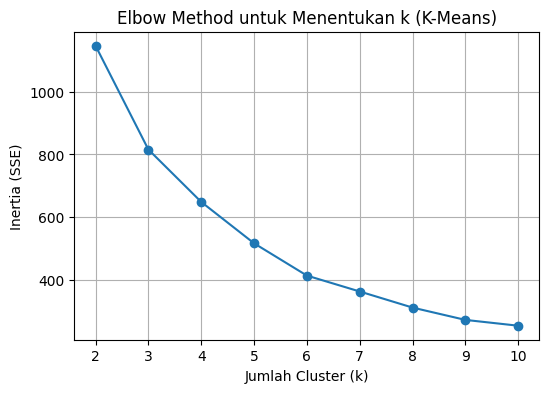

In [13]:
# ================================
# 📌 LANJUTAN: K-Means + Elbow Method
# ================================
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- 1. Pastikan kita pakai DataFrame yang benar ---
# Jika masih di cell yang sama, user_features sudah ada.
# Kalau di notebook baru, bisa load lagi dari CSV:
# user_features = pd.read_csv(os.path.join(BASE_PATH, "user_features_final_pandas.csv"))


# --- 3. Pilih fitur numerik untuk clustering ---
feature_cols = [
    "jumlah_postingan",
    "like_diberikan",
    "like_diterima",
    "komen_diberikan",
    "komen_diterima",
    "jumlah_teman",
]

X = user_features[feature_cols].copy()

# (Safety) Kalau masih ada NaN, isi dengan median
X = X.fillna(X.median(numeric_only=True))

# --- 4. Scaling fitur (penting untuk K-Means) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 5. Elbow Method: hitung inertia untuk berbagai nilai k ---
inertias = []
k_values = range(2, 11)  # misal kita coba k dari 2 sampai 10

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10  # beberapa kali inisialisasi supaya lebih stabil
    )
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)  # total SSE / inertia

# --- 6. Tampilkan nilai inertia per k di console (biar bisa dicek juga) ---
for k, inertia in zip(k_values, inertias):
    print(f"k = {k}, inertia = {inertia:.2f}")

# --- 7. Plot grafik Elbow ---
plt.figure(figsize=(6, 4))
plt.plot(k_values, inertias, marker="o")
plt.xticks(k_values)
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method untuk Menentukan k (K-Means)")
plt.grid(True)
plt.show()


In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for k in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    print(f"k = {k}, silhouette = {sil:.4f}")


k = 2, silhouette = 0.6496
k = 3, silhouette = 0.3976
k = 4, silhouette = 0.4015
k = 5, silhouette = 0.4236
k = 6, silhouette = 0.4247
k = 7, silhouette = 0.3983
k = 8, silhouette = 0.3864
k = 9, silhouette = 0.3791
k = 10, silhouette = 0.3784


In [31]:
from sklearn.cluster import KMeans
import os

# ================================
# 📌 Training K-Means final dengan k = 4
# ================================

k_final = 4

kmeans_final = KMeans(
    n_clusters=k_final,
    random_state=42,
    n_init=10
)

# Fit ke data yang sudah di-scale
labels_k4 = kmeans_final.fit_predict(X_scaled)

# Simpan label cluster ke dataframe user_features
user_features["cluster_k4"] = labels_k4

# Lihat jumlah anggota tiap cluster
print("Jumlah user per cluster (k=4):")
print(user_features["cluster_k4"].value_counts().sort_index())

# Ringkasan fitur per cluster
cluster_summary_k4 = user_features.groupby("cluster_k4")[feature_cols].mean()
print("\nRingkasan rata-rata fitur per cluster (k=4):")
print(cluster_summary_k4)

# (Opsional) simpan hasil
out_path_k4 = os.path.join(BASE_PATH, "user_features_kmeans_k4.csv")
user_features.to_csv(out_path_k4, index=False)
print("\nHasil K-Means (k=4) disimpan di:", out_path_k4)


Jumlah user per cluster (k=4):
cluster_k4
0    166
1     22
2    135
3      7
Name: count, dtype: int64

Ringkasan rata-rata fitur per cluster (k=4):
            jumlah_postingan  like_diberikan  like_diterima  komen_diberikan  \
cluster_k4                                                                     
0                   1.921687      219.728916      12.391566       239.542169   
1                   7.136364        1.090909    1273.545455         2.500000   
2                   4.392593      221.703704      50.066667       142.807407   
3                  19.571429        0.857143    4162.571429         9.571429   

            komen_diterima  jumlah_teman  
cluster_k4                                
0               118.373494      5.915663  
1                 3.318182      1.727273  
2               291.688889      5.925926  
3                 9.142857      4.000000  

Hasil K-Means (k=4) disimpan di: /content/drive/MyDrive/DataOSSN/user_features_kmeans_k4.csv


In [32]:
user_features["cluster_k4"].value_counts()

,count
cluster_k4,
0,166
2,135
1,22
3,7


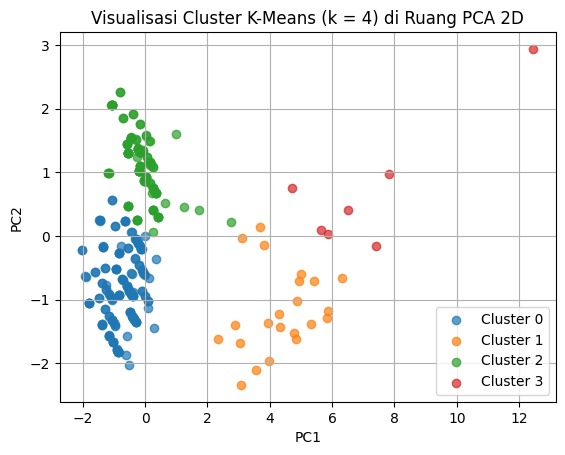

In [33]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# PCA ke 2 dimensi
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Ambil label cluster
labels = user_features["cluster_k4"].values

plt.figure()

for cl in sorted(np.unique(labels)):
    mask = labels == cl
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=f"Cluster {cl}",
        alpha=0.7
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Visualisasi Cluster K-Means (k = 4) di Ruang PCA 2D")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
!pip install scikit-learn-extra


/usr/local/lib/python3.12/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 


=== K-Medoids Elbow ===
k = 2, inertia = 580.61
k = 3, inertia = 571.63
k = 4, inertia = 439.04
k = 5, inertia = 418.71
k = 6, inertia = 408.28
k = 7, inertia = 395.00
k = 8, inertia = 357.78
k = 9, inertia = 351.40
k = 10, inertia = 349.61


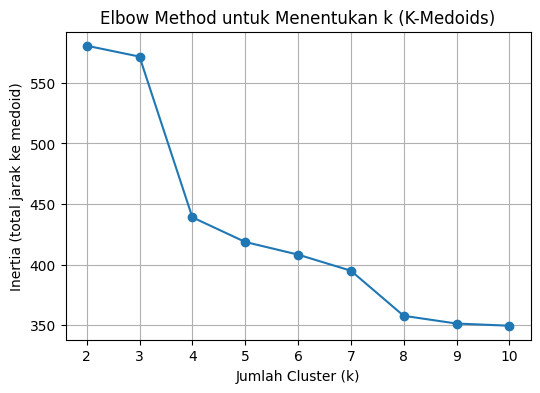

In [36]:
# ================================
# 📌 Elbow Method untuk K-Medoids
# ================================
from sklearn_extra.cluster import KMedoids

inertias_kmed = []
k_values = range(2, 11)  # sama seperti K-Means: k = 2 s.d. 10

for k in k_values:
    kmedoids = KMedoids(
        n_clusters=k,
        metric="euclidean",
        random_state=42
    )
    kmedoids.fit(X_scaled)
    # Mirip K-Means, K-Medoids juga punya inertia_ (total jarak ke medoid)
    inertias_kmed.append(kmedoids.inertia_)

# Tampilkan nilai inertia per k di console
print("\n=== K-Medoids Elbow ===")
for k, inertia in zip(k_values, inertias_kmed):
    print(f"k = {k}, inertia = {inertia:.2f}")

# Plot grafik Elbow K-Medoids
plt.figure(figsize=(6, 4))
plt.plot(k_values, inertias_kmed, marker="o")
plt.xticks(k_values)
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Inertia (total jarak ke medoid)")
plt.title("Elbow Method untuk Menentukan k (K-Medoids)")
plt.grid(True)
plt.show()


In [39]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score

for k in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    kmedoids = KMedoids(
        n_clusters=k,
        metric="euclidean",
        random_state=42
    )
    labels = kmedoids.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    print(f"k = {k}, silhouette (K-Medoids) = {sil:.4f}")


k = 2, silhouette (K-Medoids) = 0.1434
k = 3, silhouette (K-Medoids) = 0.0015
k = 4, silhouette (K-Medoids) = 0.3372
k = 5, silhouette (K-Medoids) = 0.2474
k = 6, silhouette (K-Medoids) = 0.1789
k = 7, silhouette (K-Medoids) = 0.1929
k = 8, silhouette (K-Medoids) = 0.2284
k = 9, silhouette (K-Medoids) = 0.2756
k = 10, silhouette (K-Medoids) = 0.2553


/usr/local/lib/python3.12/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 

In [40]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ================================
# ƒ K-Medoids dengan k = 4
# ================================

k_med = 4

kmedoids = KMedoids(
    n_clusters=k_med,
    metric="euclidean",
    random_state=42
)

labels_kmed4 = kmedoids.fit_predict(X_scaled)

# Simpan ke dataframe
user_features["cluster_kmed4"] = labels_kmed4

# Silhouette untuk K-Medoids
sil_kmed4 = silhouette_score(X_scaled, labels_kmed4)
print(f"Silhouette K-Medoids (k=4): {sil_kmed4:.4f}")

# Jumlah user per cluster
print("\nJumlah user per cluster (K-Medoids, k=4):")
print(user_features["cluster_kmed4"].value_counts().sort_index())

# Ringkasan rata-rata fitur per cluster
cluster_summary_kmed4 = user_features.groupby("cluster_kmed4")[feature_cols].mean()


out_path_k4 = os.path.join(BASE_PATH, "user_features_kmedoids_k4.csv")
user_features.to_csv(out_path_k4, index=False)
print("\nHasil K-Means (k=4) disimpan di:", out_path_k4)

Silhouette K-Medoids (k=4): 0.3372

Jumlah user per cluster (K-Medoids, k=4):
cluster_kmed4
0     66
1     43
2    106
3    115
Name: count, dtype: int64

Hasil K-Means (k=4) disimpan di: /content/drive/MyDrive/DataOSSN/user_features_kmedoids_k4.csv


/usr/local/lib/python3.12/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(


In [35]:
user_features["cluster_kmed4"].value_counts()

,count
cluster_kmed4,
3,115
2,106
0,66
1,43


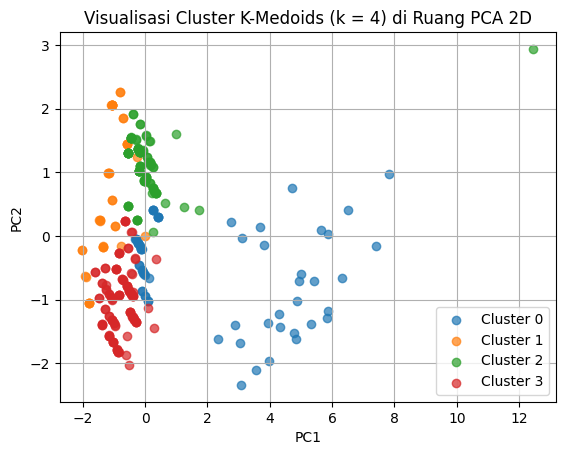

In [19]:
# Kalau belum ada PCA:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

labels_m = user_features["cluster_kmed4"].values

plt.figure()
for cl in sorted(np.unique(labels_m)):
    mask = labels_m == cl
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        alpha=0.7,
        label=f"Cluster {cl}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Visualisasi Cluster K-Medoids (k = 4) di Ruang PCA 2D")
plt.legend()
plt.grid(True)
plt.show()


Masih coba-coba

In [44]:
import time
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

# Pastikan X_scaled sudah ada
# Pastikan feature_cols & user_features sudah ada

k_candidates = [4]

results = []

# ======================
# K-MEANS
# ======================
for k in k_candidates:
    start = time.time()
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels = kmeans.fit_predict(X_scaled)
    elapsed = time.time() - start

    sil = silhouette_score(X_scaled, labels)
    db  = davies_bouldin_score(X_scaled, labels)
    ch  = calinski_harabasz_score(X_scaled, labels)
    inertia = kmeans.inertia_

    results.append({
        "algo": "kmeans",
        "k": k,
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch,
        "inertia": inertia,
        "time_sec": elapsed,
        "empty_cluster": False
    })

# ======================
# K-MEDOIDS
# ======================
for k in k_candidates:
    start = time.time()
    kmed = KMedoids(
        n_clusters=k,
        metric="euclidean",
        random_state=42
    )
    labels = kmed.fit_predict(X_scaled)
    elapsed = time.time() - start

    counts = np.bincount(labels, minlength=k)
    has_empty = (counts == 0).any()

    if has_empty:
        sil = np.nan
        db  = np.nan
        ch  = np.nan
    else:
        sil = silhouette_score(X_scaled, labels)
        db  = davies_bouldin_score(X_scaled, labels)
        ch  = calinski_harabasz_score(X_scaled, labels)

    inertia = getattr(kmed, "inertia_", np.nan)

    results.append({
        "algo": "kmedoids",
        "k": k,
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch,
        "inertia": inertia,
        "time_sec": elapsed,
        "empty_cluster": has_empty
    })

results_df = pd.DataFrame(results)

print("=== HASIL TUNING MENTAH (K-Means & K-Medoids) ===")
print(results_df.sort_values(["algo", "k"]))


=== HASIL TUNING MENTAH (K-Means & K-Medoids) ===
       algo  k  silhouette  davies_bouldin  calinski_harabasz     inertia  \
0    kmeans  4    0.401493        0.962623         222.929242  648.862047   
1  kmedoids  4    0.337245        1.307528          82.951618  439.042412   

   time_sec  empty_cluster  
0  0.063062          False  
1  1.596995          False  


/usr/local/lib/python3.12/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(


In [45]:
# Buang konfigurasi yang cluster-nya kosong atau silhouette NaN
valid_results = results_df[
    (~results_df["empty_cluster"]) &
    (~results_df["silhouette"].isna())
].copy()

print("\n=== KANDIDAT VALID ===")
print(valid_results.sort_values(["silhouette"], ascending=False))

# Pilih model terbaik:
# 1) silhouette paling besar
# 2) kalau seri, Davies-Bouldin paling kecil
best = (
    valid_results
    .sort_values(
        ["silhouette", "davies_bouldin"],
        ascending=[False, True]
    )
    .iloc[0]
)

best_algo = best["algo"]
best_k    = int(best["k"])

print("\n=== MODEL TERPILIH ===")
print(f"Algoritma         : {best_algo}")
print(f"Jumlah cluster    : {best_k}")
print(f"Silhouette        : {best['silhouette']:.4f}")
print(f"Davies-Bouldin    : {best['davies_bouldin']:.4f}")
print(f"Calinski-Harabasz : {best['calinski_harabasz']:.2f}")
print(f"Inertia           : {best['inertia']:.2f}")
print(f"Waktu komputasi   : {best['time_sec']:.4f} detik")



=== KANDIDAT VALID ===
       algo  k  silhouette  davies_bouldin  calinski_harabasz     inertia  \
0    kmeans  4    0.401493        0.962623         222.929242  648.862047   
1  kmedoids  4    0.337245        1.307528          82.951618  439.042412   

   time_sec  empty_cluster  
0  0.063062          False  
1  1.596995          False  

=== MODEL TERPILIH ===
Algoritma         : kmeans
Jumlah cluster    : 4
Silhouette        : 0.4015
Davies-Bouldin    : 0.9626
Calinski-Harabasz : 222.93
Inertia           : 648.86
Waktu komputasi   : 0.0631 detik


In [47]:
# ================================
# 📌 TRAINING MODEL FINAL (HASIL SELEKSI)
# ================================
if best_algo == "kmeans":
    final_model = KMeans(
        n_clusters=best_k,
        random_state=42,
        n_init=10
    )
else:
    final_model = KMedoids(
        n_clusters=best_k,
        metric="euclidean",
        random_state=42
    )

final_labels = final_model.fit_predict(X_scaled)

user_features["cluster_final"] = final_labels

print("\nJumlah user per cluster (model final):")
print("Model nya adalah:", final_model)
print(user_features["cluster_final"].value_counts().sort_index())

cluster_summary_final = user_features.groupby("cluster_final")[feature_cols].mean()
print("\nRingkasan rata-rata fitur per cluster (model final):")
print(cluster_summary_final)

# Simpan hasil
out_path_final = os.path.join(BASE_PATH, "user_features_cluster_final.csv")
user_features.to_csv(out_path_final, index=False)
print("\nData dengan cluster_final disimpan di:", out_path_final)



Jumlah user per cluster (model final):
Model nya adalah: KMeans(n_clusters=4, n_init=10, random_state=42)
cluster_final
0    166
1     22
2    135
3      7
Name: count, dtype: int64

Ringkasan rata-rata fitur per cluster (model final):
               jumlah_postingan  like_diberikan  like_diterima  \
cluster_final                                                    
0                      1.921687      219.728916      12.391566   
1                      7.136364        1.090909    1273.545455   
2                      4.392593      221.703704      50.066667   
3                     19.571429        0.857143    4162.571429   

               komen_diberikan  komen_diterima  jumlah_teman  
cluster_final                                                 
0                   239.542169      118.373494      5.915663  
1                     2.500000        3.318182      1.727273  
2                   142.807407      291.688889      5.925926  
3                     9.571429        9.142857     

In [48]:
print(cluster_summary_final)
print(user_features["cluster_final"].value_counts())


               jumlah_postingan  like_diberikan  like_diterima  \
cluster_final                                                    
0                      1.921687      219.728916      12.391566   
1                      7.136364        1.090909    1273.545455   
2                      4.392593      221.703704      50.066667   
3                     19.571429        0.857143    4162.571429   

               komen_diberikan  komen_diterima  jumlah_teman  
cluster_final                                                 
0                   239.542169      118.373494      5.915663  
1                     2.500000        3.318182      1.727273  
2                   142.807407      291.688889      5.925926  
3                     9.571429        9.142857      4.000000  
cluster_final
0    166
2    135
1     22
3      7
Name: count, dtype: int64


In [49]:
# ================================
# 📌 Tambahkan Nama Kategori Cluster
# ================================

# Mapping nama kategori berdasarkan cluster_final
cluster_names = {
    0: "Pengguna Aktif Interaksi",
    1: "Kreator Populer Pasif",
    2: "Pengguna Aktif Seimbang",
    3: "Kreator Super Populer"
}

# Tambahkan kolom nama cluster
user_features["cluster_final_name"] = user_features["cluster_final"].map(cluster_names)

# Cek hasil
print(user_features[["cluster_final", "cluster_final_name"]].head())

# Ringkas jumlah per kategori
print("\nJumlah user per kategori:")
print(user_features["cluster_final_name"].value_counts())

output_named = os.path.join(BASE_PATH, "user_features_cluster_final_named.csv")
user_features.to_csv(output_named, index=False)
print("\nDataset dengan nama kategori disimpan di:", output_named)


   cluster_final     cluster_final_name
0              1  Kreator Populer Pasif
1              1  Kreator Populer Pasif
2              1  Kreator Populer Pasif
3              1  Kreator Populer Pasif
4              3  Kreator Super Populer

Jumlah user per kategori:
cluster_final_name
Pengguna Aktif Interaksi    166
Pengguna Aktif Seimbang     135
Kreator Populer Pasif        22
Kreator Super Populer         7
Name: count, dtype: int64

Dataset dengan nama kategori disimpan di: /content/drive/MyDrive/DataOSSN/user_features_cluster_final_named.csv


In [51]:
# ============================================
# 2️⃣ Definisikan jalur naik kelas kategori
#    0 → 2 → 1 → 3
# ============================================

upgrade_path = {
    0: 2,  # Interaktor → Aktif Seimbang
    2: 1,  # Aktif Seimbang → Kreator Populer
    1: 3,  # Kreator Populer → Super Populer
    3: None  # sudah level tertinggi
}

# ============================================
# 3️⃣ Fungsi rekomendasi naik kelas per user_id
# ============================================

def recommend_upgrade_for_user(user_id, df_user, cluster_summary, feature_cols, upgrade_path, cluster_names):
    """
    Mengembalikan:
      - cluster sekarang + nama
      - cluster target + nama (kalau ada)
      - delta fitur (berapa banyak yang perlu ditambah)
    """
    # Cari baris user
    row = df_user[df_user["user_id"] == user_id]
    if row.empty:
        raise ValueError(f"user_id {user_id} tidak ditemukan.")

    row = row.iloc[0]

    current_cluster = int(row["cluster_final"])
    current_name = cluster_names.get(current_cluster, f"Cluster {current_cluster}")

    target_cluster = upgrade_path.get(current_cluster, None)
    if target_cluster is None:
        # Sudah di level tertinggi
        return {
            "user_id": user_id,
            "current_cluster": current_cluster,
            "current_name": current_name,
            "target_cluster": None,
            "target_name": None,
            "needed_increase": None,
            "note": "User sudah berada pada kategori tertinggi. Tidak ada kelas di atasnya."
        }

    target_name = cluster_names.get(target_cluster, f"Cluster {target_cluster}")

    # Ambil rata-rata target cluster sebagai patokan
    target_means = cluster_summary.loc[target_cluster, feature_cols]

    # Nilai user saat ini
    current_vals = row[feature_cols]

    # Hitung selisih target - current
    diffs = target_means - current_vals

    # Hanya ambil yang positif (butuh dinaikkan)
    diffs = diffs.clip(lower=0)

    # Bulatkan ke atas (ceil) dan jadikan int
    diffs_ceil = np.ceil(diffs).astype(int)

    return {
        "user_id": user_id,
        "current_cluster": current_cluster,
        "current_name": current_name,
        "target_cluster": target_cluster,
        "target_name": target_name,
        "needed_increase": diffs_ceil.to_dict(),
        "note": "Nilai adalah tambahan minimal agar mendekati rata-rata kategori target."
    }

# ============================================
# 4️⃣ Contoh pemanggilan fungsi
# ============================================

# Misalnya kita tes untuk satu user tertentu
contoh_user_id = user_features["user_id"].iloc[0]  # atau isi manual id-nya

recommendation = recommend_upgrade_for_user(
    user_id=contoh_user_id,
    df_user=user_features,
    cluster_summary=cluster_summary_final,
    feature_cols=feature_cols,
    upgrade_path=upgrade_path,
    cluster_names=cluster_names
)

print("Rekomendasi naik kelas untuk user:", recommendation["user_id"])
print("Kategori saat ini :", recommendation["current_name"])
print("Target kategori   :", recommendation["target_name"])
print("Catatan           :", recommendation["note"])
print("\nTambahan yang disarankan:")
if recommendation["needed_increase"] is not None:
    for feat, inc in recommendation["needed_increase"].items():
        if inc > 0:
            print(f" - {feat}: +{inc}")
        else:
            print(f" - {feat}: sudah >= rata-rata target")

Rekomendasi naik kelas untuk user: 2
Kategori saat ini : Kreator Populer Pasif
Target kategori   : Kreator Super Populer
Catatan           : Nilai adalah tambahan minimal agar mendekati rata-rata kategori target.

Tambahan yang disarankan:
 - jumlah_postingan: +9
 - like_diberikan: sudah >= rata-rata target
 - like_diterima: +2780
 - komen_diberikan: sudah >= rata-rata target
 - komen_diterima: +7
 - jumlah_teman: sudah >= rata-rata target


In [52]:
import numpy as np

# ============================================
# 1️⃣ Definisikan distribusi rekomendasi per cluster
# ============================================

# Maksimal rekomendasi per user
MAX_RECS = 10

# Distribusi rekomendasi berdasarkan cluster_final user
# key   : cluster user saat ini
# value : dict {cluster_target: jumlah rekomendasi dari cluster itu}
friend_distribution = {
    0: {  # Interaktor Sosial Aktif
        0: 5,  # sesama interaktor
        2: 3,  # aktif seimbang
        1: 2   # kreator populer
    },
    2: {  # Pengguna Aktif Seimbang
        2: 4,  # sesama seimbang
        0: 3,  # interaktor
        1: 3   # kreator populer
    },
    1: {  # Kreator Populer
        1: 5,  # sesama kreator populer
        2: 3,  # aktif seimbang
        3: 2   # super populer
    },
    3: {  # Kreator Super Populer (Influencer)
        3: 4,  # sesama super populer
        2: 4,  # aktif seimbang
        1: 2   # kreator populer
    }
}

# ============================================
# 2️⃣ Fungsi rekomendasi teman berdasarkan user_id
# ============================================

def recommend_friends_by_cluster(
    user_id,
    df_user,
    max_total=MAX_RECS,
    distribution_map=friend_distribution,
    random_state=None
):
    """
    Rekomendasi teman berdasarkan cluster:
      - Input  : user_id
      - Output : DataFrame berisi user lain (maks max_total) dengan kombinasi cluster sesuai distribusi.
    """
    # Pastikan user ada
    row = df_user[df_user["user_id"] == user_id]
    if row.empty:
        raise ValueError(f"user_id {user_id} tidak ditemukan di user_features.")
    row = row.iloc[0]

    current_cluster = int(row["cluster_final"])
    current_name = row.get("cluster_final_name", f"Cluster {current_cluster}")

    if current_cluster not in distribution_map:
        # fallback: kalau cluster tidak ada di distribusi, rekomendasikan dari cluster yang sama saja
        dist = {current_cluster: max_total}
    else:
        dist = distribution_map[current_cluster]

    # Kumpulkan rekomendasi di list
    rec_rows = []
    total_added = 0

    # Untuk reproducibility optional
    rng = np.random.RandomState(random_state) if random_state is not None else None

    for target_cluster, target_n in dist.items():
        if total_added >= max_total:
            break

        # Hitung sisa slot
        remaining_slots = max_total - total_added
        if remaining_slots <= 0:
            break

        n_to_take = min(target_n, remaining_slots)

        # Kandidat user: cluster sesuai, bukan dirinya sendiri
        candidates = df_user[
            (df_user["cluster_final"] == target_cluster) &
            (df_user["user_id"] != user_id)
        ]

        if candidates.empty:
            continue

        # Kalau kandidat kurang dari kuota, ambil semuanya
        if len(candidates) <= n_to_take:
            sampled = candidates
        else:
            if rng is not None:
                # sampling dengan random_state
                sampled = candidates.sample(n=n_to_take, random_state=rng)
            else:
                sampled = candidates.sample(n=n_to_take)

        rec_rows.append(sampled)
        total_added += len(sampled)

    if not rec_rows:
        # Tidak ada rekomendasi sama sekali
        return current_cluster, current_name, df_user.iloc[0:0]  # DataFrame kosong

    rec_df = (
        pd.concat(rec_rows, axis=0)
        .drop_duplicates(subset=["user_id"])
        .head(max_total)  # jaga-jaga kalau kelebihan
    )

    return current_cluster, current_name, rec_df

# ============================================
# 3️⃣ Contoh penggunaan
# ============================================

# Misal kita pilih satu user_id contoh
contoh_user_id = user_features["user_id"].iloc[0]  # ganti dengan id nyata

current_cluster, current_name, rec_df = recommend_friends_by_cluster(
    user_id=contoh_user_id,
    df_user=user_features,
    max_total=10,
    distribution_map=friend_distribution,
    random_state=42
)

print(f"User {contoh_user_id} saat ini di cluster {current_cluster} - {current_name}")
print("Rekomendasi teman (maks 10):")
# Tampilkan kolom penting aja
cols_show = ["user_id", "username", "cluster_final", "cluster_final_name"]
cols_show = [c for c in cols_show if c in rec_df.columns]
print(rec_df[cols_show])


User 2 saat ini di cluster 1 - Kreator Populer Pasif
Rekomendasi teman (maks 10):
     user_id               username  cluster_final       cluster_final_name
1          3            KhoirulFuad              1    Kreator Populer Pasif
26        34         fajarsaputra12              1    Kreator Populer Pasif
21        29               Jenjenny              1    Kreator Populer Pasif
2          4            ErikBakrie1              1    Kreator Populer Pasif
13        15                  Fajar              1    Kreator Populer Pasif
216      224    rimbatales_moon_224              2  Pengguna Aktif Seimbang
221      229     pagiwarm_raven_229              2  Pengguna Aktif Seimbang
246      254  rimbatales_clover_254              2  Pengguna Aktif Seimbang
23        31                AstaKun              3    Kreator Super Populer
5          7                  Rizky              3    Kreator Super Populer


In [53]:
import pickle
import os

# ================================
# 📦 Paket untuk rekomendasi NAIK KELAS
# ================================
upgrade_package = {
    "scaler": scaler,                        # StandardScaler yang sudah fit
    "model": final_model,                    # Model clustering final (K-Means k=4)
    "feature_cols": feature_cols,            # Daftar fitur
    "cluster_names": cluster_names,          # Nama kategori per cluster
    "cluster_summary": cluster_summary_final, # Rata-rata fitur per cluster
    "upgrade_path": upgrade_path             # Jalur naik kelas (0→2→1→3)
}

upgrade_pkl_path = os.path.join(BASE_PATH, "cluster_upgrade_model.pkl")

with open(upgrade_pkl_path, "wb") as f:
    pickle.dump(upgrade_package, f)

print("File .pkl untuk NAIK KELAS disimpan di:", upgrade_pkl_path)

# ================================
# 📦 Paket untuk REKOMENDASI TEMAN
# ================================
friendrec_package = {
    "scaler": scaler,                         # Supaya bisa klasifikasikan user baru
    "model": final_model,                     # Model clustering yang sama
    "feature_cols": feature_cols,             # Fitur yang digunakan
    "cluster_names": cluster_names,           # Nama kategori
    "friend_distribution": friend_distribution # Aturan pembagian rekomendasi teman
}

friendrec_pkl_path = os.path.join(BASE_PATH, "cluster_friend_recommender.pkl")

with open(friendrec_pkl_path, "wb") as f:
    pickle.dump(friendrec_package, f)

print("File .pkl untuk REKOMENDASI TEMAN disimpan di:", friendrec_pkl_path)


File .pkl untuk NAIK KELAS disimpan di: /content/drive/MyDrive/DataOSSN/cluster_upgrade_model.pkl
File .pkl untuk REKOMENDASI TEMAN disimpan di: /content/drive/MyDrive/DataOSSN/cluster_friend_recommender.pkl
